In [2]:
# All the necesarry libraries
import pandas as pd
import zipfile
import os
import random
import torch
from ultralytics import YOLOWorld
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision import models
from IPython.display import display
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

In [3]:
# Define paths
root_dir = '/home/catalin/proiect'
v1_dir = os.path.join(root_dir, 'detailed_weldings')

Displaying some training images from version 1:


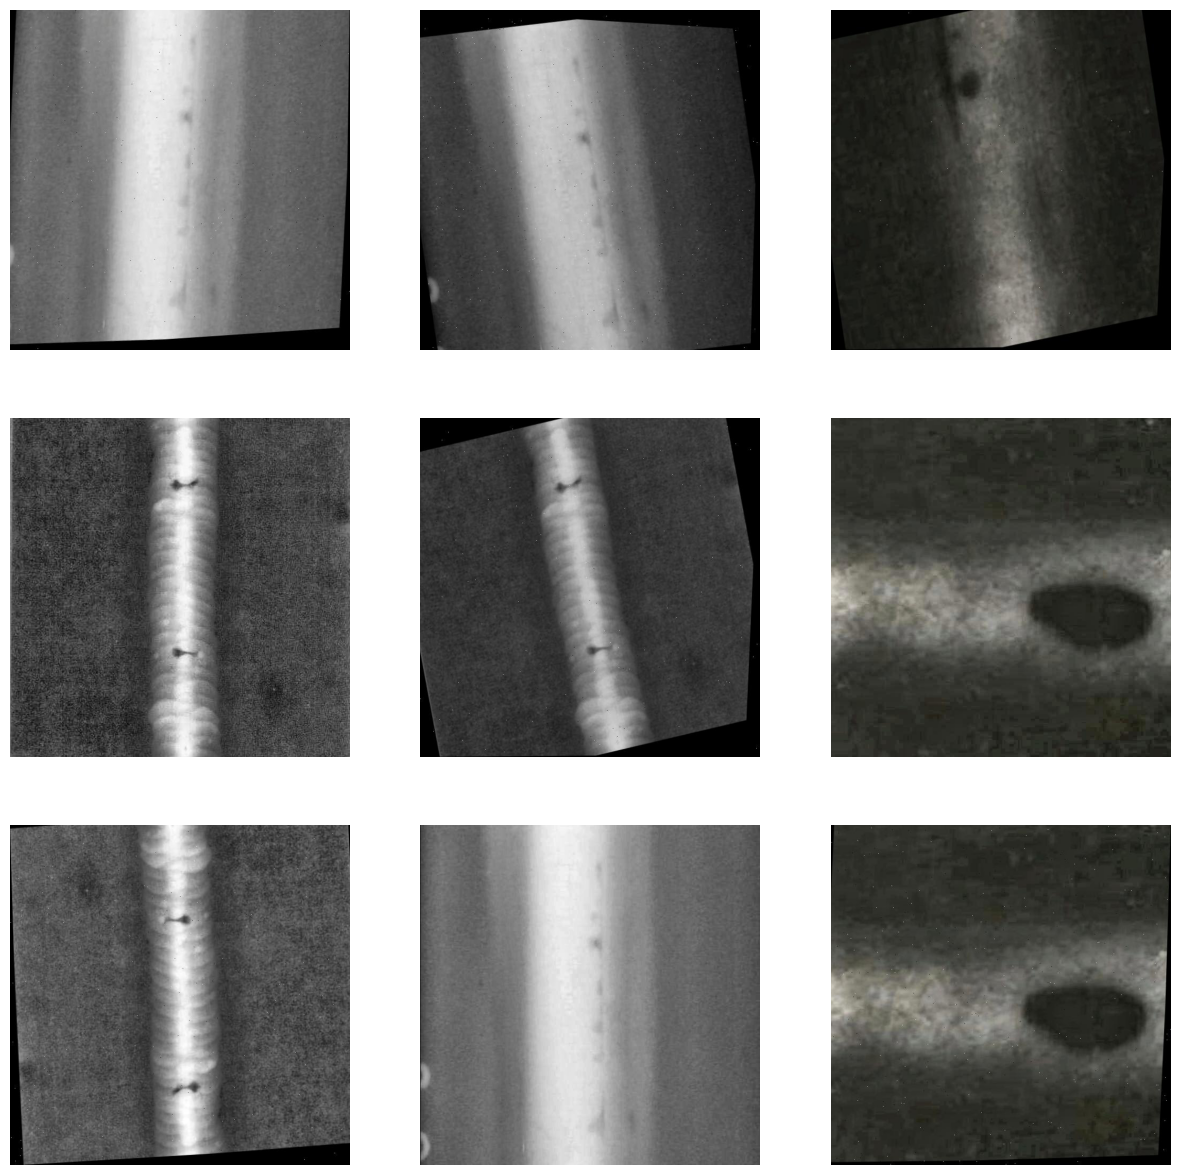

In [4]:
# Function to display images, modify num_images to show how much images you want
def display_images(image_dir, num_images=9):
    images = os.listdir(image_dir)
    sample_images = random.sample(images, num_images)
    plt.figure(figsize=(15, 15))
    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.show()

# Display some training images
print("Displaying some training images from version 1:")
display_images(os.path.join(v1_dir, 'train/images'))

In [5]:
def update_data_yaml(data_yaml_path, base_dir):

    data_yaml_path = os.path.expanduser(data_yaml_path)
    base_dir = os.path.expanduser(base_dir)
    
    # Read file data.yaml
    with open(data_yaml_path, 'r') as file:
        data_yaml = file.read()
    
    # update file paths
    data_yaml = data_yaml.replace('../train/images', os.path.join(base_dir, 'train/images'))
    data_yaml = data_yaml.replace('../valid/images', os.path.join(base_dir, 'valid/images'))
    data_yaml = data_yaml.replace('../test/images', os.path.join(base_dir, 'test/images'))
    
    # Write updates
    with open(data_yaml_path, 'w') as file:
        file.write(data_yaml)

# paths
data_yaml_path = '/home/catalin/proiect/detailed_weldings/data.yaml'
base_dir = '/home/catalin/proiect/detailed_weldings'

# Update file data.yaml
update_data_yaml(data_yaml_path, base_dir)

# Check results
def print_data_yaml(data_yaml_path):
    data_yaml_path = os.path.expanduser(data_yaml_path)
    with open(data_yaml_path, 'r') as file:
        print(file.read())

print("Updated data.yaml:")
print_data_yaml(data_yaml_path)


Updated data.yaml:
train: /home/catalin/proiect/detailed_weldings/train/images
val: /home/catalin/proiect/detailed_weldings/valid/images
test: /home/catalin/proiect/detailed_weldings/test/images

nc: 4
names: ['Crack', 'LoP-LoF', 'Pore', 'Slag']

roboflow:
  workspace: project-u4wny
  project: demo_1-9tvhj
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/project-u4wny/demo_1-9tvhj/dataset/2


In [6]:
import gc
gc.collect()

17752

In [7]:
# EDA and Preprocessing
def load_labels(label_dir):
    label_files = os.listdir(label_dir)
    data = []
    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                data.append([label_file, class_id, x_center, y_center, width, height])
    df = pd.DataFrame(data, columns=['file', 'class_id', 'x_center', 'y_center', 'width', 'height'])
    return df

v1_train_labels = load_labels(os.path.join(v1_dir, 'train/labels'))

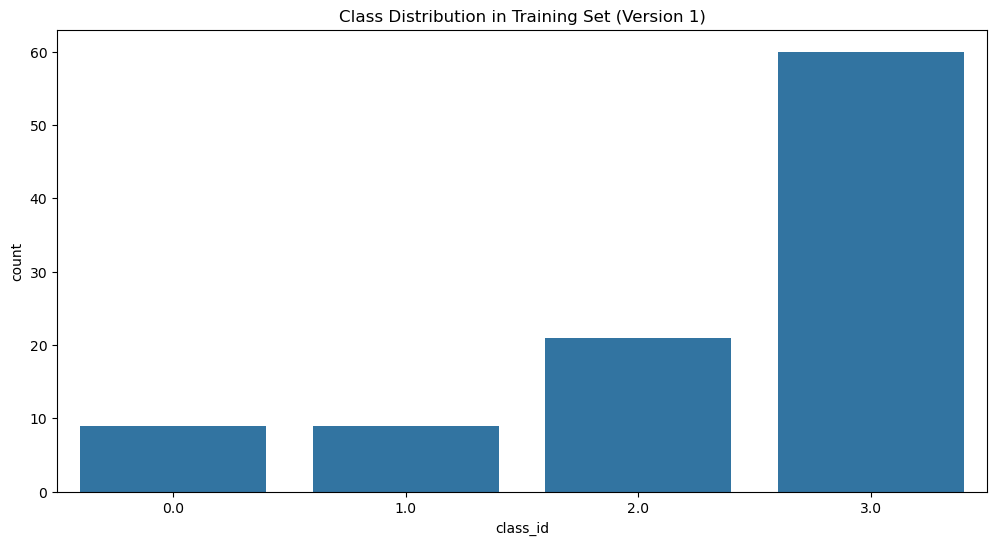

In [8]:
# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=v1_train_labels, x='class_id')
plt.title('Class Distribution in Training Set (Version 1)')
plt.show()

In [9]:
# Initialize the model
model_v1 = YOLOWorld("/home/catalin/proiect/yolov8l-world.pt")

In [18]:
model_v1.train(
    data='/home/catalin/proiect/detailed_weldings/data.yaml',
    epochs=300,
    imgsz=640,
    batch=16,
    name='welding_v1_optimized',
    
    # Learning Rate and Optimization
    lr0=0.0005,
    lrf=0.01,
    momentum=0.9,
    weight_decay=0.0005,
    
    # Warmup Strategies
    warmup_epochs=3,  # Slightly reduced warmup
    warmup_momentum=0.9,
    warmup_bias_lr=0.1,
    
    # Loss Balancing
    box=5.0,    
    cls=1.0,    
    dfl=2.0,    
    iou=0.2,
    
    # Data Augmentation
    hsv_h=0.1,  
    hsv_s=0.5,  
    hsv_v=0.3,  
    translate=0.1,  
    scale=0.3,  
    mosaic=0.5,  
    mixup=0.3,  
    copy_paste=0.3,  
    
    # Regularization Techniques
    patience=50,
    dropout=0.2,
    label_smoothing=0.2,
    
    # Performance Optimization
    workers=8,
    device=0,
    
    # Advanced Training Options
    close_mosaic=50,  # Mosaic ends at epoch 50
    cos_lr=True,
    overlap_mask=True,
    max_det=300,
)


New https://pypi.org/project/ultralytics/8.3.49 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.40 🚀 Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)
engine/trainer: task=detect, mode=train, model=/home/catalin/proiect/yolov8l-world.pt, data=/home/catalin/proiect/detailed_weldings/data.yaml, epochs=300, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=welding_v1_optimized3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=50, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.2, max_det=300, half=False, dnn=False, plots=True, source=None, vid_

train: Scanning /home/catalin/proiect/detailed_weldings/train/labels.cache... 57 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57/57 [00:00<?, ?it/s]
val: Scanning /home/catalin/proiect/detailed_weldings/valid/labels.cache... 213 images, 1 backgrounds, 0 corrupt: 100%|██████████| 213/213 [00:00<?, ?it/s]


Plotting labels to runs/detect/welding_v1_optimized3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.9' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 104 weight(decay=0.0), 122 weight(decay=0.0005), 128 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/welding_v1_optimized3
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      1/300      11.7G      1.142       2.38      2.422         32        640: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]

                   all        213        477      0.435      0.138      0.108     0.0335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      2/300      11.9G      1.096      2.097      2.404         28        640: 100%|██████████| 4/4 [00:00<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.63it/s]

                   all        213        477      0.358      0.152     0.0789     0.0225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      3/300        12G      1.075      2.212      2.215         32        640: 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]

                   all        213        477      0.366      0.153     0.0764     0.0211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      4/300        12G      1.017      2.119      2.217         24        640: 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.59it/s]

                   all        213        477      0.134      0.178     0.0609     0.0165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      5/300        12G      1.053      2.066      2.359         26        640: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]

                   all        213        477      0.125      0.175     0.0576     0.0149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      6/300        12G      1.102      2.164       2.34         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.59it/s]

                   all        213        477      0.128      0.201     0.0576     0.0148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      7/300      12.2G      0.959      1.885      2.173         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]

                   all        213        477      0.109      0.228     0.0713     0.0194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      8/300      12.1G      1.052      2.039      2.271         18        640: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]

                   all        213        477       0.14       0.21     0.0862     0.0228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      9/300      12.1G     0.9798      2.052      2.257         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.58it/s]

                   all        213        477      0.141      0.197     0.0809     0.0217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     10/300      12.1G      1.031      2.008      2.286         33        640: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]

                   all        213        477      0.127      0.215      0.065     0.0184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     11/300      12.1G      1.077      2.139      2.328         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]

                   all        213        477      0.104      0.192     0.0607     0.0163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     12/300      12.1G      0.966      1.951      2.163         30        640: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]

                   all        213        477     0.0997      0.211     0.0622     0.0162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     13/300      12.1G      1.126      2.364      2.394         31        640: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]

                   all        213        477      0.138      0.226     0.0882     0.0203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     14/300        12G      1.015      1.938      2.263         28        640: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.63it/s]

                   all        213        477      0.169        0.2      0.095     0.0232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     15/300        12G     0.9773      1.793      2.133         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.66it/s]

                   all        213        477      0.376      0.112     0.0825     0.0246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     16/300        12G      1.031      2.047       2.28         18        640: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.65it/s]

                   all        213        477      0.364      0.135     0.0774     0.0232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     17/300      12.3G       1.06      1.985      2.305         36        640: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.65it/s]

                   all        213        477      0.404      0.124     0.0924     0.0274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     18/300        12G      1.037      2.171      2.218         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.63it/s]

                   all        213        477      0.138      0.167     0.0966     0.0247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     19/300      12.1G       1.03      2.042      2.234         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.64it/s]

                   all        213        477      0.186      0.196      0.105     0.0279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     20/300      12.1G      1.026      1.991      2.256         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]

                   all        213        477      0.189      0.248       0.12     0.0326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     21/300        12G      1.012      1.908       2.23         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]

                   all        213        477      0.242      0.193      0.135     0.0308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     22/300      11.8G       1.02      1.979      2.208         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]

                   all        213        477      0.178      0.155      0.133     0.0366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     23/300        12G      1.004      1.873      2.196         17        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]

                   all        213        477      0.158      0.172      0.112     0.0337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     24/300        12G      1.086      2.204      2.297         27        640: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]

                   all        213        477      0.372      0.129     0.0961     0.0268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     25/300        12G      1.047      2.108      2.313         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.57it/s]

                   all        213        477       0.61      0.122      0.076     0.0194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     26/300        12G      1.026      1.935       2.26         19        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]

                   all        213        477      0.196      0.144     0.0884     0.0227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     27/300      12.1G     0.9798      2.103      2.168         31        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]

                   all        213        477      0.133       0.15     0.0892     0.0243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     28/300        12G      1.107      1.941      2.368         31        640: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.56it/s]

                   all        213        477      0.104      0.207     0.0564      0.015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     29/300      12.2G     0.9342      1.758       2.13         19        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]

                   all        213        477     0.0777      0.206     0.0448     0.0126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     30/300      12.1G     0.9795      1.952      2.147         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]

                   all        213        477     0.0785      0.196      0.046     0.0117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     31/300      12.1G     0.9559      1.791      2.219         29        640: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]

                   all        213        477     0.0765      0.184     0.0482     0.0137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     32/300      12.2G     0.9569      1.916      2.148         20        640: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.57it/s]

                   all        213        477     0.0815      0.193     0.0484     0.0155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     33/300      12.1G     0.9594      1.933      2.199         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]

                   all        213        477      0.125      0.205     0.0708     0.0236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     34/300      12.1G     0.9163      1.921      2.142         27        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]

                   all        213        477       0.13      0.224      0.077     0.0213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     35/300      12.2G     0.9932      1.887      2.209         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.58it/s]

                   all        213        477      0.119      0.189     0.0717      0.022



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     36/300      12.2G     0.9529      1.862      2.157         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]

                   all        213        477     0.0943      0.185     0.0533      0.016



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     37/300      12.2G     0.9547      1.968      2.114         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]

                   all        213        477     0.0895      0.174     0.0546     0.0167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     38/300      12.2G     0.8969      1.921      2.134         28        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]

                   all        213        477     0.0896      0.207     0.0614     0.0174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     39/300        12G     0.9143      1.704      2.097         31        640: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]

                   all        213        477      0.125      0.178     0.0738     0.0208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     40/300      12.2G     0.9926      1.871      2.229         36        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.64it/s]

                   all        213        477      0.159       0.19     0.0736     0.0201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     41/300      12.1G     0.9816      1.836        2.1         28        640: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.63it/s]

                   all        213        477      0.161      0.194     0.0936      0.024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     42/300        12G     0.9704      1.845      2.245         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]

                   all        213        477       0.14      0.179     0.0881     0.0254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     43/300        12G     0.9278      1.881      2.156         33        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]

                   all        213        477      0.388      0.154     0.0926     0.0259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     44/300        12G     0.9542      1.845      2.117         20        640: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.58it/s]

                   all        213        477       0.39      0.157      0.105     0.0323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     45/300      12.2G      1.005      1.845      2.171         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.59it/s]

                   all        213        477      0.163       0.18      0.101     0.0275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     46/300      12.2G     0.9688      1.962      2.138         26        640: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.58it/s]

                   all        213        477      0.142       0.16     0.0838     0.0211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     47/300        12G     0.9539      2.014      2.163         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]

                   all        213        477        0.1      0.171     0.0706     0.0212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     48/300      11.8G      1.001      1.858      2.132         27        640: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]

                   all        213        477      0.159      0.169     0.0773     0.0225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     49/300      12.2G     0.9065      1.751      2.121         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]

                   all        213        477      0.132      0.166     0.0667     0.0195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     50/300        12G     0.9533      1.803      2.163         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]

                   all        213        477      0.085      0.158     0.0546     0.0166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     51/300      12.2G     0.8885      1.686       2.04         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]

                   all        213        477     0.0815       0.14     0.0452     0.0109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     52/300        12G     0.9851      1.701      2.214         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]

                   all        213        477      0.113      0.124     0.0581      0.016



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     53/300        12G     0.9529      1.855      2.131         31        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]

                   all        213        477      0.172      0.145     0.0903     0.0252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     54/300        12G     0.9967      1.796      2.087         28        640: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.59it/s]

                   all        213        477      0.175      0.172     0.0852     0.0242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     55/300      12.1G      0.922      1.689      2.014         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.52it/s]

                   all        213        477      0.137      0.174     0.0765     0.0215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     56/300        12G     0.9502      1.833      2.207         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.47it/s]

                   all        213        477      0.133      0.152     0.0645     0.0174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     57/300        12G     0.8972      1.863       2.06         27        640: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.44it/s]

                   all        213        477      0.459      0.115     0.0678     0.0201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     58/300        12G     0.9325      1.712      2.088         20        640: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]

                   all        213        477      0.612      0.122     0.0597     0.0162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     59/300        12G     0.8793      1.692      2.033         33        640: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.52it/s]

                   all        213        477       0.17       0.23     0.0623     0.0157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     60/300        12G     0.8783       1.72      2.089         16        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.56it/s]

                   all        213        477      0.124      0.202     0.0672     0.0157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     61/300      12.1G     0.9723        1.8       2.13         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.58it/s]

                   all        213        477     0.0804      0.207     0.0628     0.0148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     62/300      12.2G     0.9115      1.628      2.059         27        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.57it/s]

                   all        213        477     0.0594      0.191     0.0499     0.0123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     63/300        12G     0.9893      1.802      2.131         33        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.40it/s]

                   all        213        477     0.0858      0.197     0.0701     0.0159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     64/300        12G     0.8944      1.603      1.994         31        640: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.47it/s]

                   all        213        477      0.123       0.16     0.0976     0.0228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     65/300      12.1G     0.8923      1.563       2.03         22        640: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]

                   all        213        477       0.11      0.209      0.083     0.0198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     66/300      11.8G     0.9686       1.78      2.149         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]

                   all        213        477      0.122      0.198     0.0575     0.0128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     67/300        12G     0.9153      1.747      2.013         39        640: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]

                   all        213        477     0.0975      0.195     0.0483     0.0121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     68/300        12G     0.9283      1.765          2         28        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]

                   all        213        477      0.105      0.193     0.0762     0.0231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     69/300        12G     0.9201      1.579      2.135         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.64it/s]

                   all        213        477      0.124      0.195      0.082     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     70/300        12G      0.911      1.659      2.038         18        640: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.64it/s]

                   all        213        477      0.143       0.19     0.0844     0.0274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     71/300      12.2G     0.8535      1.619      1.953         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.65it/s]

                   all        213        477      0.171      0.181     0.0974      0.031



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:00<?, ?it/s]/home/catalin/.conda/envs/yolo/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     72/300        12G     0.9048      1.688      2.026         28        640: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.64it/s]

                   all        213        477      0.164      0.163     0.0941      0.027
EarlyStopping: Training stopped early as no improvement observed in last 50 epochs. Best results observed at epoch 22, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



72 epochs completed in 0.043 hours.
Optimizer stripped from runs/detect/welding_v1_optimized3/weights/last.pt, 95.5MB
Optimizer stripped from runs/detect/welding_v1_optimized3/weights/best.pt, 95.5MB

Validating runs/detect/welding_v1_optimized3/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)
YOLOv8l-world summary (fused): 311 layers, 47,529,842 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]


                   all        213        477      0.178      0.155      0.133     0.0366
                 Crack         45        141          0          0     0.0111    0.00216
               LoP-LoF        103        106      0.128      0.142     0.0724     0.0112
                  Pore         78        187      0.549      0.267      0.285      0.067
                  Slag         36         43     0.0364      0.209      0.162      0.066
Speed: 0.1ms preprocess, 2.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/welding_v1_optimized3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x73ef10234a00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

Displaying results from model trained on version 1 with augmentation:

image 1/1 /home/catalin/proiect/detailed_weldings/test/images/IMG_202403115021_640x640_jpg.rf.f861e128864af7d16b1db2fbb5a75610.jpg: 640x640 (no detections), 8.1ms
Speed: 9.9ms preprocess, 8.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

Detections in IMG_202403115021_640x640_jpg.rf.f861e128864af7d16b1db2fbb5a75610.jpg:
  No detections found

image 1/1 /home/catalin/proiect/detailed_weldings/test/images/IMG_202403115796_640x640_jpg.rf.98eedaf139f23322af8865545b352f95.jpg: 640x640 1 Slag, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

Detections in IMG_202403115796_640x640_jpg.rf.98eedaf139f23322af8865545b352f95.jpg:
  - Slag: Confidence 0.74

image 1/1 /home/catalin/proiect/detailed_weldings/test/images/IMG_202403111842_640x640_jpg_jpg.rf.ba5a39db83fb9bf8c9c8479de359e2c8.jpg: 640x640 (no detections), 9.2ms
Speed: 1.2ms preprocess, 9.2ms in

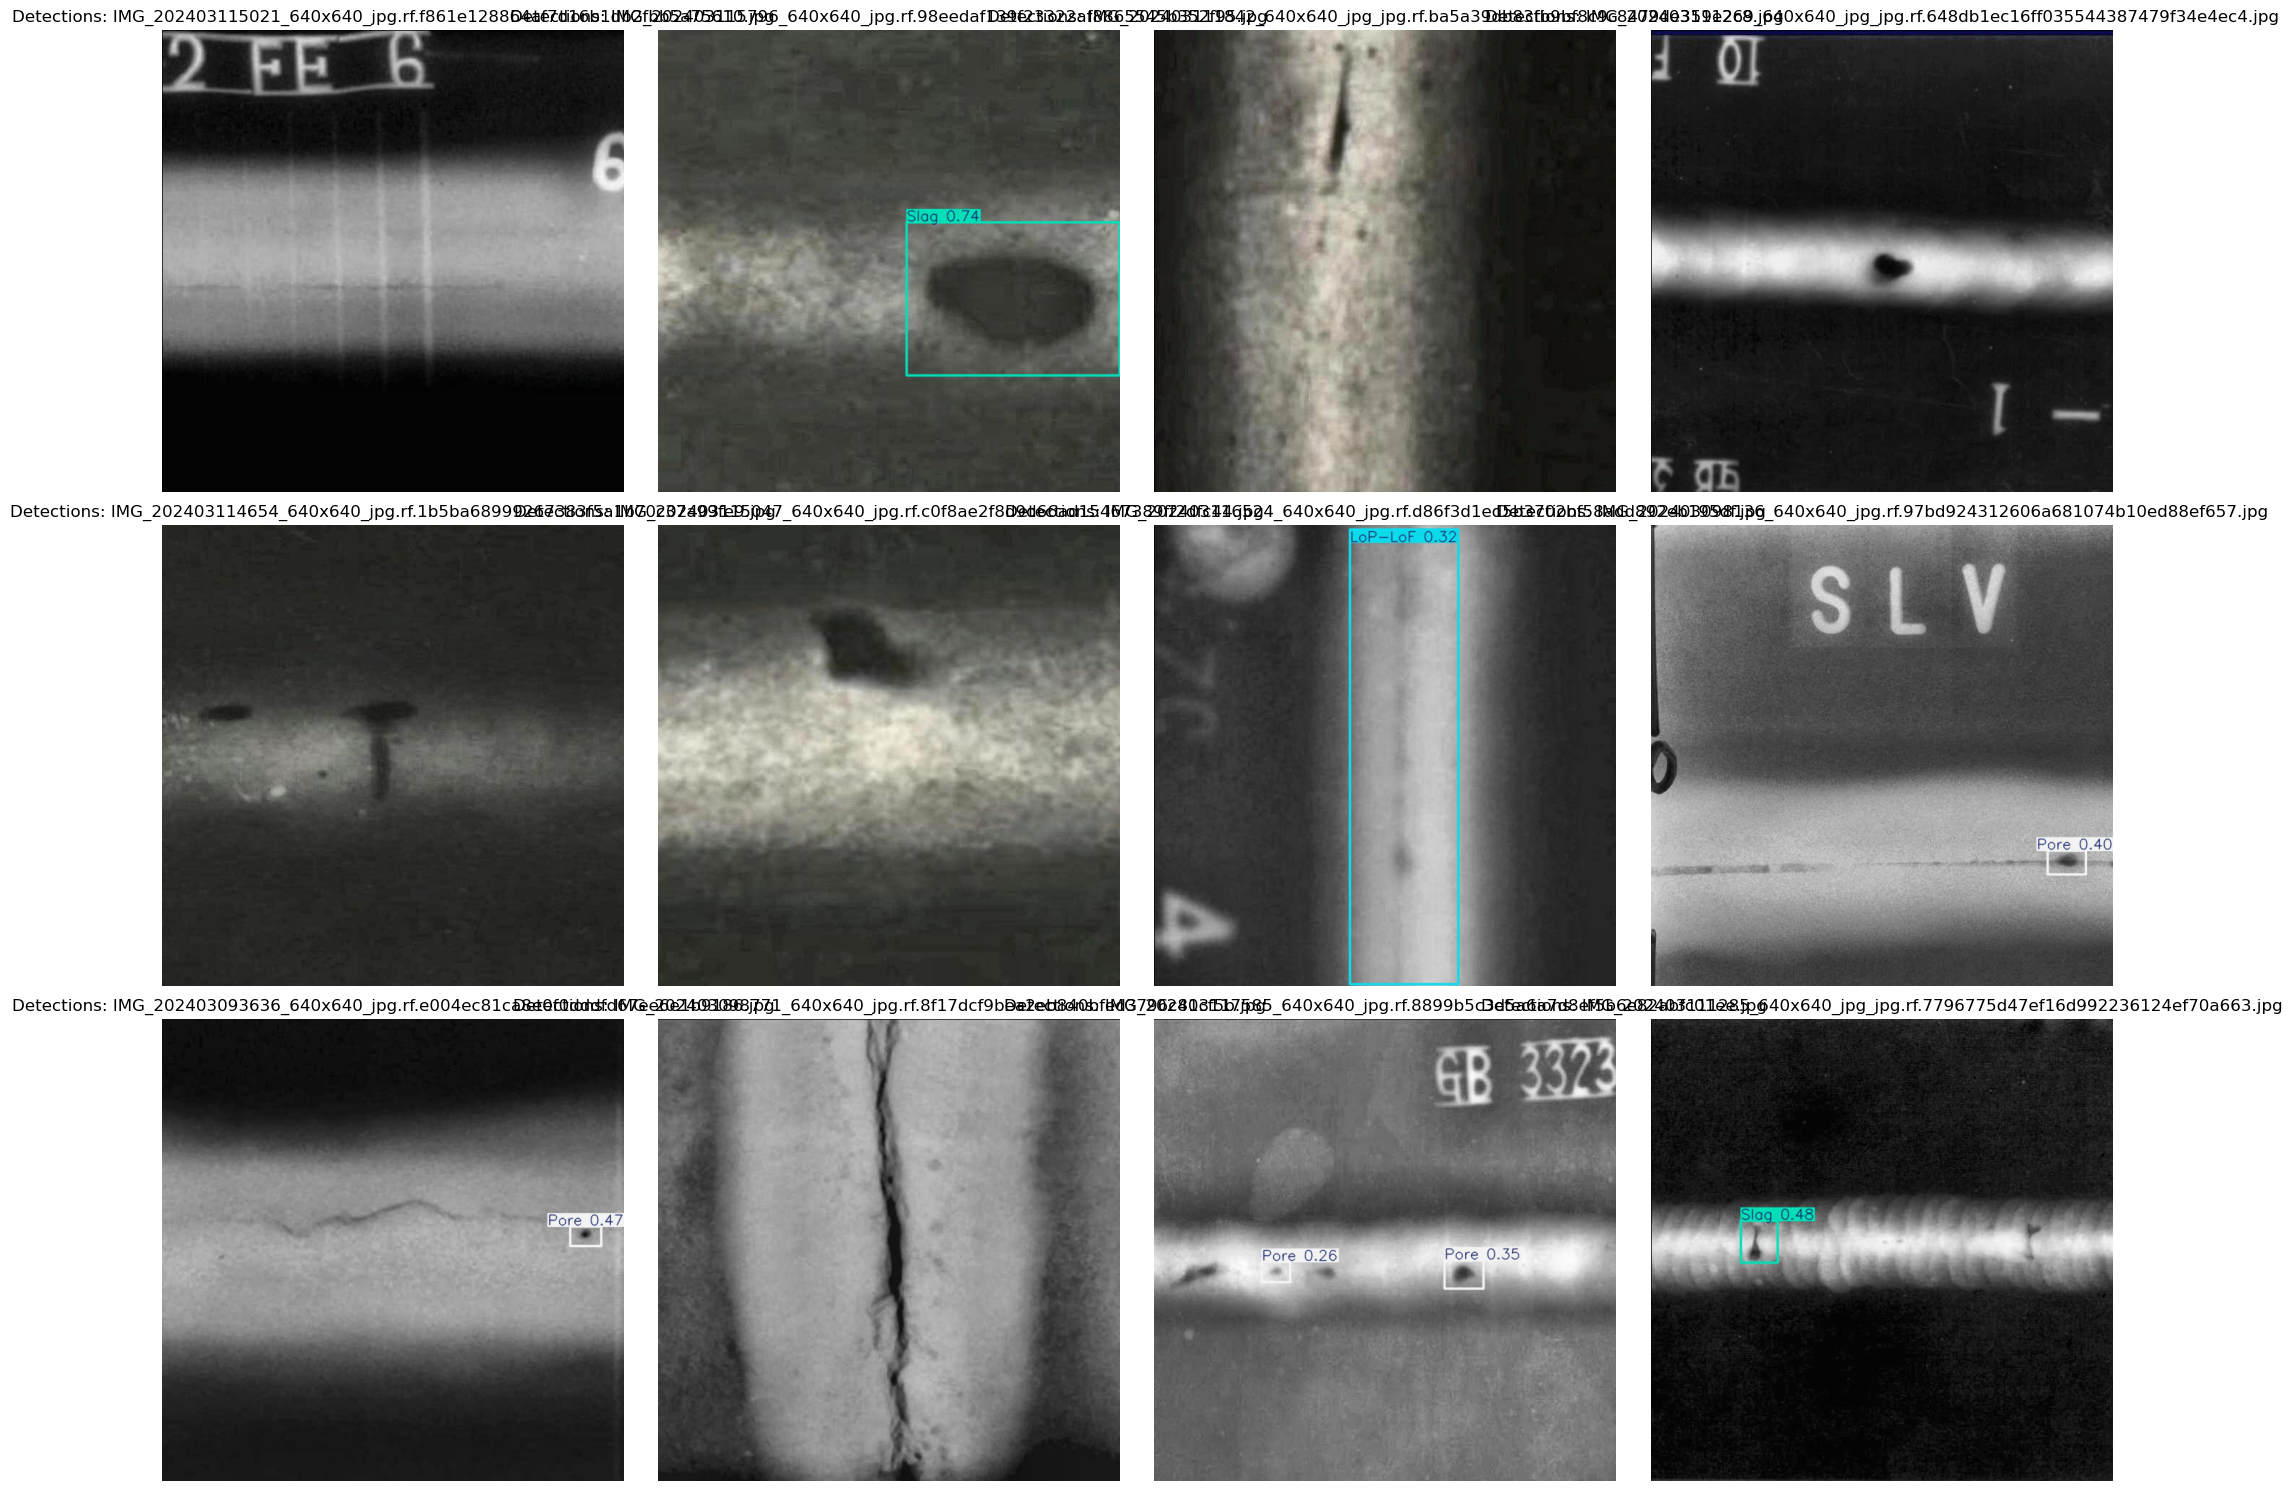

In [28]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from PIL import Image
 
def display_results(model, img_dir, num_images=12, conf_threshold=0.25, save_dir='runs/detect/exp'):
    """
    Evaluate the model and display results with comprehensive visualization
    
    Args:
        model: Trained YOLO model
        img_dir: Directory containing test images
        num_images: Number of random images to process
        conf_threshold: Confidence threshold for detections
        save_dir: Directory to save result images
    """
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Filter valid image files
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif']
    images = [f for f in os.listdir(img_dir) if os.path.splitext(f)[1].lower() in valid_extensions]
    
    # Randomly sample images
    sample_images = random.sample(images, min(num_images, len(images)))
    
    # Prepare subplot grid
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.ravel()
    
    for idx, image_name in enumerate(sample_images):
        # Construct full image path
        image_path = os.path.join(img_dir, image_name)
        
        try:
            # Perform inference with confidence threshold
            results = model(image_path, conf=conf_threshold)
            
            # Plot and save results
            for result in results:
                # Save annotated image
                result_path = os.path.join(save_dir, f'result_{image_name}')
                result.save(result_path)
                
                # Read the annotated image
                img = cv2.imread(result_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Display on subplot
                axes[idx].imshow(img)
                axes[idx].set_title(f'Detections: {image_name}')
                axes[idx].axis('off')
                
                # Print detection details
                print(f"\nDetections in {image_name}:")
                if len(result.boxes) > 0:
                    for box in result.boxes:
                        cls = int(box.cls[0])
                        conf = float(box.conf[0])
                        print(f"  - {model.names[cls]}: Confidence {conf:.2f}")
                else:
                    print("  No detections found")
        
        except Exception as e:
            print(f"Error processing {image_name}: {e}")
            # Display a blank or error image if processing fails
            axes[idx].text(0.5, 0.5, f'Error: {e}', 
                            horizontalalignment='center', 
                            verticalalignment='center')
            axes[idx].axis('off')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Usage example
print("Displaying results from model trained on version 1 with augmentation:")
display_results(
    model_v1, 
    os.path.join(v1_dir, 'test/images'), 
    num_images=12,  # Adjust number of images to display
    conf_threshold=0.25  # Adjust confidence threshold
)